In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import re
import os
import asyncio
import json
import nltk
import random

from parallel_reddit_scrape import Scraper
import dotenv

from dotenv import load_dotenv

load_dotenv()

True

# This is a jupyter file to be used to perform analysis on reddit posts

Firstly, we're going to need to define our search targets. We want to pull data from different parts of reddit

In [3]:
limit = 500
timeframe = 'year' #hour, day, week, month, year, all
listing = 'relevance' # controversial, best, hot, new, random, rising, top

topics = ['blockchain', 'defi', 'digital assets', 'NFT', 'cryptocurrency', 'crypto', 'blockchain development','blockchain network', 'crypto exchange']
companies = [
 'Mojito',
 'TaxBit',
 'ConsenSys Software Inc',
 'BlockFi',
 'Bitfury',
 'Blockdaemon',
 'RECUR',
 'Chainalysis',
 'Coinbase',
 'Unstoppable Domains',
 'Coinme Inc.',
 'Axoni',
 'Paxful',
 'IBM',
 'Republic',
 'Spring Labs',
 'Galaxy',
 'SALT',
 'Mythical Games',
 'Anchorage Digital',
 'Robinhood',
 'Lemonade',
 'Circle',
 'Algorand',
 'Paxos',
 'Ripple',
 'Lockheed Martin',
 'Nium',
 'Ford Motor Company',
 'TQ Tezos',
 'BRD',
 'NYDIG',
 'BitMEX',
 'Netki',
 'Celsius',
 'Nisum',
 'Bloq',
 'doc.ai',
 'MoonPay',
 'TrustToken',
 'Oasis Labs',
 'Chronicled',
 'High Fidelity',
 'ANKR',
 'VOATZ',
 'STEEM',
 'Omega Grid',
 'Filecoin',
 'Mediachain',
 'ShipChain']

comp_urls = []
topic_urls = []
for comp in companies:
    comp = comp.replace(' ', '%20')
    comp_urls.append(f'https://www.reddit.com/search.json?q={comp}&limit={limit}&t={timeframe}&sort={listing}&type=link')
    topic_urls.append(f'https://www.reddit.com/search.json?q={comp}&limit={limit}&t={timeframe}&sort={listing}&type=sr')
for topic in topics: 
    topic = topic.replace(' ', '%20')
    topic_urls.append(f'https://www.reddit.com/search.json?q={topic}&limit={limit}&t={timeframe}&sort={listing}&type=sr')

In [4]:
# we want to set up a NLP model to analyze our text with (as a rough approximation)
# in preparation for this, we need to create a function that will tokenize strings into sentences.

# We'll use NLTK's pretrained VADER model (which is good for social media analysis) as a simple sentiment model our textual data
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


def get_compound(string: str):
    if string == '':
        return 0
    scores = [sia.polarity_scores(sentence)['compound'] for sentence in nltk.sent_tokenize(string)]
    return np.nanmean(scores)


# First, we'll find out where the content we want to look at is being posted

In [5]:
scrape_communities = Scraper()
df = scrape_communities.reddit_function(topic_urls)
df[['id','created_utc','url','display_name','public_description','subreddit_type','advertiser_category','community_reviewed','subscribers','accounts_active']]

An Error Occured
An Error Occured
An Error Occured


,id,created_utc,url,display_name,public_description,subreddit_type,advertiser_category,community_reviewed,subscribers,accounts_active
0,2s3qj,1.284043e+09,/r/Bitcoin/,Bitcoin,Bitcoin is the currency of the Internet: a dis...,public,Business / Finance,True,4655407.0,None
0,zv1lv,1.555440e+09,/r/unstoppabledomains/,unstoppabledomains,Making crypto payments simple and building dec...,public,,True,2439.0,None
1,2wlj3,1.363039e+09,/r/CryptoCurrency/,CryptoCurrency,"The leading community for cryptocurrency news,...",public,Business / Finance,True,5595418.0,None
2,2zf9m,1.387038e+09,/r/ethereum/,ethereum,Next-generation platform for decentralised app...,public,,True,1517917.0,None
3,3nl60,1.502555e+09,/r/zilliqa/,zilliqa,Zilliqa is a layer 1 protocol and dapp develop...,public,,True,44434.0,None
...,...,...,...,...,...,...,...,...,...,...
52,6f0u5j,1.653361e+09,/r/JubiCryptoExchange/,JubiCryptoExchange,,restricted,,False,39.0,None
53,5dnzt3,1.637666e+09,/r/BitYardCryptoExchange/,BitYardCryptoExchange,BitYard is a one-stop trading platform for glo...,public,,False,19.0,None
54,lpr51,1.531472e+09,/r/EXMO_Official/,EXMO_Official,EXMO is an International Cryptocurrency Exchan...,restricted,,False,15203.0,None
55,28eb0q,1.573711e+09,/r/Zipmex_official/,Zipmex_official,Zipmex is a fully licensed Singapore-based dig...,restricted,,False,1483.0,None


In [84]:
# then we apply some basic transformations to filter the data slightly and get a more accurate result

subreddits = df[['id','url','display_name','public_description','description_html', 'subreddit_type','advertiser_category','community_reviewed','subscribers','accounts_active']]
subreddits = subreddits[(subreddits['public_description'].str.contains(pat=r'blockchain|crypto|defi |digital asset|nft', case=False)) & (subreddits['subscribers'] > 500)].drop_duplicates()
subreddits

,id,url,display_name,public_description,description_html,subreddit_type,advertiser_category,community_reviewed,subscribers,accounts_active
0,zv1lv,/r/unstoppabledomains/,unstoppabledomains,Making crypto payments simple and building dec...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,2439.0,None
1,2wlj3,/r/CryptoCurrency/,CryptoCurrency,"The leading community for cryptocurrency news,...",&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,Business / Finance,True,5595418.0,None
4,ldcor,/r/Crypto_com/,Crypto_com,"Crypto.com is the best place to buy, sell, and...",&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,183698.0,None
8,3bx7j,/r/NFT/,NFT,The NFT subreddit is a gathering for those int...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,539954.0,None
9,3jmmc,/r/BATProject/,BATProject,Basic Attention Token (BAT) is a revolutionary...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,True,88849.0,None
...,...,...,...,...,...,...,...,...,...,...
49,3mrqr,/r/BlockCat/,BlockCat,"BlockCAT lets anyone create, manage, and deplo...",&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,public,,False,815.0,None
13,mspx1,/r/XeraExchange/,XeraExchange,The XERA exchange are transforming the way cry...,&amp;lt;!-- SC_OFF --&amp;gt;&amp;lt;div class...,restricted,,False,9363.0,None
30,3m708,/r/javvy/,javvy,MORE THAN A CRYPTO WALLET!\nMORE THAN A CRYPTO...,None,restricted,,False,950.0,None
54,lpr51,/r/EXMO_Official/,EXMO_Official,EXMO is an International Cryptocurrency Exchan...,None,restricted,,False,15203.0,None


# Before finishing with our first table, we want to add some sentiment modeling for further analysis later on

We'll do so with NLTK and their VADER model

In [85]:


# first, let's just pull our text related information out of the main table
subreddit_descriptions = subreddits[['id','display_name','public_description']].rename(columns={'id':'subreddit_id'}).reset_index().drop('index',axis=1).set_index('subreddit_id')

# then we'll iterate through the table, creating a new list to store the sentiment data.

subreddit_descriptions['subreddit_sentiment'] = [get_compound(description) for description in subreddit_descriptions['public_description']]


# ss = [] # ss = subreddit sentiment
# for id, row in subreddit_descriptions.iterrows():
#     ss.append({'id':id,'subreddit_sentiment':sentiment['compound']})
# subreddit_descriptions = subreddit_descriptions.merge(pd.DataFrame(ss), how='left', on='id')
# we're only going to keep the compound sentiment scores for future analysis because we'll be adding several other compound scores together

# we also want to create a list to filter the posts submissions on in the next section
subreddit_list = subreddits['display_name'].to_list()

subreddit_descriptions


,display_name,public_description,subreddit_sentiment
subreddit_id,,,
zv1lv,unstoppabledomains,Making crypto payments simple and building dec...,0.000000
2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000
ldcor,Crypto_com,"Crypto.com is the best place to buy, sell, and...",0.254600
3bx7j,NFT,The NFT subreddit is a gathering for those int...,0.411933
3jmmc,BATProject,Basic Attention Token (BAT) is a revolutionary...,0.420600
...,...,...,...
3mrqr,BlockCat,"BlockCAT lets anyone create, manage, and deplo...",0.381800
mspx1,XeraExchange,The XERA exchange are transforming the way cry...,0.159100
3m708,javvy,MORE THAN A CRYPTO WALLET!\nMORE THAN A CRYPTO...,0.226240


# Now that we have out communities, we can query reddit for all posts related to our company list

In [8]:
scrape_posts = Scraper()
gf = scrape_posts.reddit_function(comp_urls)

In [9]:
posts = gf[['id','company','created','author','title','selftext','category','content_categories','subreddit','subreddit_id','score','upvote_ratio','total_awards_received','num_comments','num_crossposts','permalink']]
len(posts)
posts = posts[posts['subreddit'].isin(subreddit_list)] # Make sure we only are getting posts from subreddits we are interested in.
posts['json_link'] = ['https://reddit.com' + x + '.json' for x in posts['permalink'].to_list()]
posts = posts[posts['score'].gt(50)].sort_values(by='score', ascending=False)
posts = posts.reset_index().drop('index',axis=1)
posts['subreddit_id'] = posts['subreddit_id'].replace(r'.._', '', regex=True)
posts['selftext'] = posts['selftext'].str.replace('\n', ' ').str.replace('*', '')
posts

/var/folders/9k/r_3qnbt90jj4607x_x98wv840000gn/T/ipykernel_30119/1079295923.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  posts['selftext'] = posts['selftext'].str.replace('\n', ' ').str.replace('*', '')


,id,company,created,author,title,selftext,category,content_categories,subreddit,subreddit_id,score,upvote_ratio,total_awards_received,num_comments,num_crossposts,permalink,json_link
0,w4jflp,Coinbase,1.658417e+09,dragondude4,A Coinbase Product Manager was Just Charged Wi...,From the Justice Department: Beginning in app...,None,None,CryptoCurrency,2wlj3,7531,0.96,15,1076,10,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,https://reddit.com/r/CryptoCurrency/comments/w...
1,xxv8kn,Celsius,1.665138e+09,itcouldbefrank,The saga that keeps on giving: Celsius publish...,As part of their bankruptcy legal proceedings ...,None,None,CryptoCurrency,2wlj3,5681,0.92,15,1256,11,/r/CryptoCurrency/comments/xxv8kn/the_saga_tha...,https://reddit.com/r/CryptoCurrency/comments/x...
2,y5gp3p,Lemonade,1.665926e+09,JackOfAllInterests1,Non binary lemonade rule,,None,None,196,2v92f,4689,1.00,0,53,0,/r/196/comments/y5gp3p/non_binary_lemonade_rule/,https://reddit.com/r/196/comments/y5gp3p/non_b...
3,vygvf1,Celsius,1.657754e+09,alphabravoccharlie,Celsius informs state regulators that it's fil...,,None,None,CryptoCurrency,2wlj3,4117,0.94,9,1234,4,/r/CryptoCurrency/comments/vygvf1/celsius_info...,https://reddit.com/r/CryptoCurrency/comments/v...
4,w1dls7,Coinbase,1.658082e+09,Oscar_G_13,"""Too big to fail"" does not exist for Coinbase ...",This subreddit has been riddled with warning a...,None,None,CryptoCurrency,2wlj3,3891,0.84,16,1013,2,/r/CryptoCurrency/comments/w1dls7/too_big_to_f...,https://reddit.com/r/CryptoCurrency/comments/w...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,yau2qm,Ripple,1.666461e+09,Timely_Cucumber1703,Why are there so many XRP/ripple youtubers?,In my recommended there are atleast 3 new XRP ...,None,None,Ripple,2r9sg,51,0.91,0,42,0,/r/Ripple/comments/yau2qm/why_are_there_so_man...,https://reddit.com/r/Ripple/comments/yau2qm/wh...
215,r0j409,TrustToken,1.637691e+09,johnarcherito,GreenTrust Token will make a new Farm on Panca...,GNT to the moon!! GreenTrust token just win t...,None,None,AllCryptoBets,3u1ogh,51,1.00,0,8,0,/r/AllCryptoBets/comments/r0j409/greentrust_to...,https://reddit.com/r/AllCryptoBets/comments/r0...
216,r121h3,TrustToken,1.637749e+09,johnarcherito,GreenTrust Token will make a new Farm on Panca...,GNT to the moon with the today farm on Pancak...,None,None,shitcoinmoonshots,44md7l,51,1.00,0,10,0,/r/shitcoinmoonshots/comments/r121h3/greentrus...,https://reddit.com/r/shitcoinmoonshots/comment...
217,r0j6l3,TrustToken,1.637691e+09,johnarcherito,GreenTrust Token will make a new Farm on Panca...,GNT to the moon!! GreenTrust token just win ...,None,None,CryptoMars,3nx961,51,0.97,0,11,0,/r/CryptoMars/comments/r0j6l3/greentrust_token...,https://reddit.com/r/CryptoMars/comments/r0j6l...


In [139]:
# pulling out some more text so that we can use it in the sentiment analysis
# again we'll create some sentiment columns for later analysis

post_text = posts[['id','subreddit_id','title','selftext']].reset_index().drop('index',axis=1).set_index('id')

#get sentiment scores for the text columns
post_text['title_sentiment'] = [get_compound(title) for title in post_text['title']]
post_text['selftext_sentiment'] = [get_compound(selftext) for selftext in post_text['selftext']]

post_text


,subreddit_id,title,selftext,title_sentiment,selftext_sentiment
id,,,,,
w4jflp,2wlj3,A Coinbase Product Manager was Just Charged Wi...,From the Justice Department: Beginning in app...,-0.5994,0.260652
xxv8kn,2wlj3,The saga that keeps on giving: Celsius publish...,As part of their bankruptcy legal proceedings ...,0.3400,-0.070312
y5gp3p,2v92f,Non binary lemonade rule,,0.0000,0.000000
vygvf1,2wlj3,Celsius informs state regulators that it's fil...,,0.0000,0.000000
w1dls7,2wlj3,"""Too big to fail"" does not exist for Coinbase ...",This subreddit has been riddled with warning a...,-0.6010,-0.308086
...,...,...,...,...,...
yau2qm,2r9sg,Why are there so many XRP/ripple youtubers?,In my recommended there are atleast 3 new XRP ...,0.0000,0.197033
r0j409,3u1ogh,GreenTrust Token will make a new Farm on Panca...,GNT to the moon!! GreenTrust token just win t...,0.0000,0.209283
r121h3,44md7l,GreenTrust Token will make a new Farm on Panca...,GNT to the moon with the today farm on Pancak...,0.0000,0.177427


# After filtering our posts, we can start to scrape all the comments on each of those posts.
### These comments will hopefully be useful for providing sentiment on the posts themselves.

In [11]:
scrape_comments = Scraper()
jsonlinks = posts['json_link'].to_list() # list from our posts DataFrame
comments = scrape_comments.get_many_jsons(jsonlinks)

An Error Occured
An Error Occured
An Error Occured
An Error Occured
An Error Occured
An Error OccuredAn Error Occured

An Error Occured
An Error Occured
An Error Occured
An Error Occured
An Error OccuredAn Error Occured

An Error Occured


In [12]:
#need to create a recursive function to get all the replies from each comment thread

def more_replies(d, depth = 1, r = [], score = 0):
    if d == '':
        return (r, depth, score)
    elif isinstance(d, dict):
        replies = d['data']['children']
        for re in replies:
            if re['kind'] != 't1':
                continue
            reply = re['data']
            r.append(reply['author'] + ': ' + reply['body'])
            score += reply['score']
            if reply['replies'] != '':
                depth += 1
                more_replies(reply['replies'], depth, r)
        return (r, depth, score)


In [23]:
# # testing our function on a specific comment thread from our data set

# nested_dict = comments[0][1]['data']['children'][0]
# # reps = more_replies(nested_dict, depth = 1, r = [])
# # reply_text = ' --- '.join(reps[0]).replace('\n', ' ')
# # reply_text
# nested_dict

In [122]:
#parsing the data and creating a DataFrame from the results

coms = comments
comm_dict = []
for com in coms:
    if not com:
        continue
    if len(com) != 2:
        continue
    comment_section_= com[1]['data']['children']

    # set up dictionary for tracking comments and comment replies per post
    for commenties in comment_section_:
        post_comments = {}
        post_comments['original_post_id'] = com[0]['data']['children'][0]['data']['id']
        post_comments['num_comments'] = len(comment_section_)
        if commenties['kind'] != 't1':
            continue
        comment = commenties['data']
        post_comments['comment_id'] = comment['id']
        post_comments['awards'] = comment['total_awards_received']
        post_comments['score'] = comment['score']
        post_comments['comment'] = comment['author'] + ': ' + comment['body']
        if comment['replies'] != '':
            reps = more_replies(comment['replies'], depth = 1, r = [])
            reply_text = '. '.join(reps[0]).replace('\n', '. ')
            post_comments['replies'] = reply_text
            post_comments['reply_score'] = reps[2]
            post_comments['thread'] = post_comments['comment'] + ' --- ' + reply_text
            token_thread = [reply.replace('\n','. ') for reply in reps[0]]
            token_thread.insert(0,post_comments['comment'])
            post_comments['tokenized_thread'] = token_thread
            post_comments['max_depth'] = reps[1]
        else:
            post_comments['replies'] = ''
            post_comments['reply_score'] = 0
            post_comments['thread'] = post_comments['comment']
            post_comments['max_depth'] = 0
            post_comments['tokenized_thread'] = [post_comments['comment']]
        comm_dict.append(post_comments)

comment_section = pd.DataFrame(comm_dict)
comment_section.drop_duplicates(subset='comment_id',keep='first').reset_index().drop('index',axis=1)

,original_post_id,num_comments,comment_id,awards,score,comment,replies,reply_score,thread,tokenized_thread,max_depth
0,y23q6y,12,is0n4k0,0,52,UsernameIWontRegret: This is especially huge a...,Asadullah1668: Let's hope so. We need more new...,16,UsernameIWontRegret: This is especially huge a...,[UsernameIWontRegret: This is especially huge ...,1
1,y23q6y,12,is0noif,0,36,watchoutImhangry: Plus Staci said that there a...,,0,watchoutImhangry: Plus Staci said that there a...,[watchoutImhangry: Plus Staci said that there ...,0
2,y23q6y,12,is0svlr,0,33,OnionFarmed824: Biggest news since the FIFA an...,"TheoTimme: Probably connected, too. The on-ram...",19,OnionFarmed824: Biggest news since the FIFA an...,[OnionFarmed824: Biggest news since the FIFA a...,2
3,y23q6y,12,is11937,0,11,no-more-alcohol: Could someone explain why thi...,lobotic: this creates a better on/off ramp to ...,25,no-more-alcohol: Could someone explain why thi...,[no-more-alcohol: Could someone explain why th...,3
4,y23q6y,12,is0zboo,0,8,Certain_Cranberry_77: This might have immediat...,,0,Certain_Cranberry_77: This might have immediat...,[Certain_Cranberry_77: This might have immedia...,0
...,...,...,...,...,...,...,...,...,...,...,...
5978,y2y7qn,61,isa5zi1,0,1,OrganikJungle: Robinhood is safe. I’ve been us...,,0,OrganikJungle: Robinhood is safe. I’ve been us...,[OrganikJungle: Robinhood is safe. I’ve been u...,0
5979,y2y7qn,61,isa8mgf,0,1,FreeDesi21: Nothing is safe in Robinhood. They...,,0,FreeDesi21: Nothing is safe in Robinhood. They...,[FreeDesi21: Nothing is safe in Robinhood. The...,0
5980,y2y7qn,61,isaug0e,0,1,Vegetable_Shape53: Not sure how many times u h...,,0,Vegetable_Shape53: Not sure how many times u h...,[Vegetable_Shape53: Not sure how many times u ...,0
5981,y2y7qn,61,isbdaji,0,1,Wide_Enthusiasm6444: ![gif](emote|free_emotes_...,,0,Wide_Enthusiasm6444: ![gif](emote|free_emotes_...,[Wide_Enthusiasm6444: ![gif](emote|free_emotes...,0


In [131]:
# now we can grab the all the comment text data from the posts comments table

comment_threads_text = comment_section[['original_post_id','comment_id','thread','tokenized_thread']].drop_duplicates(subset='comment_id').reset_index().drop(labels='index', axis=1).set_index('original_post_id')

# [~comment_section['thread'].str.contains(r'bot|deleted', case=False, flags=re.IGNORECASE)]
#get comment thread sentiment scores
comment_threads_text['thread_sentiment'] = [np.nanmean([get_compound(re.sub(r'.*:','',comment)) for comment in list_of_comments]) for list_of_comments in comment_threads_text['tokenized_thread']]

comment_threads_text

,comment_id,thread,tokenized_thread,thread_sentiment
original_post_id,,,,
y23q6y,is0n4k0,UsernameIWontRegret: This is especially huge a...,[UsernameIWontRegret: This is especially huge ...,0.414500
y23q6y,is0noif,watchoutImhangry: Plus Staci said that there a...,[watchoutImhangry: Plus Staci said that there ...,0.000000
y23q6y,is0svlr,OnionFarmed824: Biggest news since the FIFA an...,[OnionFarmed824: Biggest news since the FIFA a...,0.249245
y23q6y,is11937,no-more-alcohol: Could someone explain why thi...,[no-more-alcohol: Could someone explain why th...,0.213704
y23q6y,is0zboo,Certain_Cranberry_77: This might have immediat...,[Certain_Cranberry_77: This might have immedia...,0.067433
...,...,...,...,...
y2y7qn,isa5zi1,OrganikJungle: Robinhood is safe. I’ve been us...,[OrganikJungle: Robinhood is safe. I’ve been u...,0.159575
y2y7qn,isa8mgf,FreeDesi21: Nothing is safe in Robinhood. They...,[FreeDesi21: Nothing is safe in Robinhood. The...,-0.356800
y2y7qn,isaug0e,Vegetable_Shape53: Not sure how many times u h...,[Vegetable_Shape53: Not sure how many times u ...,-0.657600


# We now have a few tables of data, and can start to analyze it

The main focus first is the analysis of the text data
- subreddit descriptions
- post texts
- post comment threads

In [236]:
# first we can set up a few different wordlists
reddit_text = post_text.join(comment_threads_text, how='left').drop_duplicates(subset='comment_id', keep='first').reset_index().rename(columns={'index':'post_id'})

reddit_corpus = reddit_text.merge(subreddit_descriptions, on='subreddit_id', how='left').drop_duplicates(subset=['subreddit_id','post_id','comment_id'],keep='first').reset_index().drop(labels='index',axis=1)

reddit_corpus = reddit_corpus[reddit_corpus['comment_id'].notna() & reddit_corpus['comment_id'].notna() & reddit_corpus['comment_id'].notna()].reset_index().drop(labels='index',axis=1)

reddit_corpus['id'] = reddit_corpus['subreddit_id'] + '-' + reddit_corpus['post_id'] + '-' + reddit_corpus['comment_id']
reddit_corpus = reddit_corpus[['id','subreddit_id','display_name','public_description','subreddit_sentiment','post_id','title','title_sentiment','selftext','selftext_sentiment','comment_id','thread','thread_sentiment']].set_index('id')

reddit_corpus

,subreddit_id,display_name,public_description,subreddit_sentiment,post_id,title,title_sentiment,selftext,selftext_sentiment,comment_id,thread,thread_sentiment
id,,,,,,,,,,,,
2wlj3-qx0zrb-hl6igb4,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000,qx0zrb,"Oasis is excited to be working with @MetaAI , ...",0.8074,Oasis is excited to be working with [@MetaAI]...,0.88485,hl6igb4,I_can_smell_colors_: They had an ama yesterday...,0.138821
2wlj3-qx0zrb-hl8d64m,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000,qx0zrb,"Oasis is excited to be working with @MetaAI , ...",0.8074,Oasis is excited to be working with [@MetaAI]...,0.88485,hl8d64m,"theseoulplayer: Dammit Oasis, first you make W...",0.000000
2wlj3-qx0zrb-hl6iom6,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000,qx0zrb,"Oasis is excited to be working with @MetaAI , ...",0.8074,Oasis is excited to be working with [@MetaAI]...,0.88485,hl6iom6,BandAidChainLink: If you look my post history ...,0.571900
2wlj3-qx0zrb-hl6nb1g,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000,qx0zrb,"Oasis is excited to be working with @MetaAI , ...",0.8074,Oasis is excited to be working with [@MetaAI]...,0.88485,hl6nb1g,thirtydelta: Set aside your opinion of Faceboo...,0.057333
2wlj3-qx0zrb-hl730tv,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",0.000000,qx0zrb,"Oasis is excited to be working with @MetaAI , ...",0.8074,Oasis is excited to be working with [@MetaAI]...,0.88485,hl730tv,Lfodder: If this partnership was announced for...,-0.153250
...,...,...,...,...,...,...,...,...,...,...,...,...
3ohto-ychp5d-itmg4tk,3ohto,CelsiusNetwork,"A new way to earn, borrow, and pay on the bloc...",0.122367,ychp5d,Judge ruled against celsius equity holders today.,0.0000,,0.00000,itmg4tk,motownphilly888: Celsius Stockholders Lose Bid...,0.000000
3ohto-ychp5d-itmq8h3,3ohto,CelsiusNetwork,"A new way to earn, borrow, and pay on the bloc...",0.122367,ychp5d,Judge ruled against celsius equity holders today.,0.0000,,0.00000,itmq8h3,Printer-Pam: so Canadian Pension fund lost all...,-0.270850
3ohto-ychp5d-itn0j7m,3ohto,CelsiusNetwork,"A new way to earn, borrow, and pay on the bloc...",0.122367,ychp5d,Judge ruled against celsius equity holders today.,0.0000,,0.00000,itn0j7m,"motownphilly888: ""A bankruptcy judge declined ...",0.000000


We can look at the resulting full corpus and see what common Trigrams appear

This is a quick way to see if our corpus contains content roughly in the same genre of what we are looking for

In [170]:
# first we need to clean up the word list and tokenize the words
thread_c = reddit_corpus[~reddit_corpus['thread'].str.contains(r'automoderator|bot|action performed|deleted', '', flags=re.IGNORECASE)]['thread'].dropna().unique().tolist()
thread_t = reddit_corpus[~reddit_corpus['title'].str.contains(r'bot|action performed automatically', '', flags=re.IGNORECASE)]['title'].dropna().unique().tolist()
thread_p = reddit_corpus['public_description'].dropna().unique().tolist()
thread_s = reddit_corpus[~reddit_corpus['selftext'].str.contains(r'https://|&amp', '', flags=re.IGNORECASE)]['selftext'].dropna().unique().tolist()
all_text = thread_t + thread_p + thread_s + thread_c
rc = ''.join(all_text).replace('please contact moderators','').replace('amp','').replace(';','').replace('https://','').replace('action performed automatically','').lower()


stoplists = nltk.corpus.stopwords.words()

text = nltk.word_tokenize(rc)
text1 = [w for w in text if w.lower() not in stoplists and w.isalpha()]

# then we can create a text object to use for the Trigram Finder
text = nltk.Text(text1)
finder = nltk.collocations.TrigramCollocationFinder.from_words(text)
top50_trigrams = finder.ngram_fd.tabulate(50)
top50_trigrams

 ('confidential', 'smart', 'contracts')                ('happy', 'cake', 'day')         ('great', 'billion', 'dollars')           ('survive', 'bear', 'market')             ('lost', 'life', 'savings')       ('eligible', 'digital', 'assets')         ('credit', 'card', 'companies')            ('daily', 'active', 'users')         ('algorand', 'state', 'proofs')                ('shut', 'fuck', 'shut')                ('fuck', 'shut', 'fuck')       ('stake', 'skybridge', 'capital')          ('gparty', 'oasis', 'network')        ('digital', 'assets', 'celsius')            ('charged', 'wire', 'fraud')                 ('long', 'time', 'ago')              ('couple', 'years', 'ago')         ('zero', 'knowledge', 'proofs')                 ('eth', 'free', 'pass')         ('decentralized', 'btc', 'eth')              ('real', 'world', 'value')                ('fifa', 'world', 'cup')             ('make', 'money', 'crypto')    ('investment', 'contract', 'ripple') ('secure', 'computing', 'technologies') 

Looks like the Trigrams follow fall into blockchain genre jargon. 

Seems like our corpus could be good enough for some sentiment analysis.

# Now we can start to look at the top texts related to postivie (1) and negative (-1) sentiment scores

We'll start to think about posts vs. comments and how they relate
e.g. a positive sentiment post that get's largely negative comments might be a sign of a weakness for a firm. 

In [163]:
# for ease, we'll work with a copy of the reddit_corpus
rc = reddit_corpus.copy()

postive = rc[rc.max(axis=1,numeric_only=True) > 0.8][['title','selftext','thread']]
postive

,title,selftext,thread
id,,,
2wlj3-qx0zrb-hl6igb4,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,I_can_smell_colors_: They had an ama yesterday...
2wlj3-qx0zrb-hl8d64m,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,"theseoulplayer: Dammit Oasis, first you make W..."
2wlj3-qx0zrb-hl6iom6,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,BandAidChainLink: If you look my post history ...
2wlj3-qx0zrb-hl6nb1g,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,thirtydelta: Set aside your opinion of Faceboo...
2wlj3-qx0zrb-hl730tv,"Oasis is excited to be working with @MetaAI , ...",Oasis is excited to be working with [@MetaAI]...,Lfodder: If this partnership was announced for...
...,...,...,...
3ohto-y9a2p9-it89e2r,Celsius Network Hearing Update: 17M Recovered ...,Hey all! Doing a collective discussion on the ...,CooellaDeville: Thank you very much for these ...
2wlj3-y9eo46-it5coa4,"Ripple Closer to Victory, Court Orders SEC Ove...",,Rare_Chair: Step in the right direction hopefu...
2wlj3-y9vfll-it7qns1,Ripple lawyer says ‘worth the fight’ as SEC ha...,,kirtash93: I have the alcohol ready for the pa...


### interesting information that appears to largely be on topic and reflect the higher scores

Now we can begin to pull this whole thing together

We hav:
- sentiment data to address the text contained in posts and comments
- data to help us weigh the sentiment scores (post scores, upvote_ratios)
    - post scores
    - upvote ratios
    - subreddit followers (popularity)
    - subreddit privacy and community review (less important)

In [298]:
# we now want to push everything together to perform some analysis and filter out posts for companies and then address strengths + weaknesses 

#we have three main tables to connect, and then add on the sentiment table
posts_and_comments = posts.merge(comment_section, left_on='id', right_on='original_post_id', how='left', suffixes=('_post','_comment'))
posts_comments_subreddits = posts_and_comments.merge(subreddits, left_on='subreddit_id', right_on='id', how='left', suffixes=('_','_subs')).drop(labels='id_subs',axis=1).rename({'id_':'post_id','num_comments_post':'num_comments','score_post':'post_score','score_comment':'comment_score'}, axis=1)
posts_comments_subreddits['id'] = posts_comments_subreddits['subreddit_id'] + '-' + posts_comments_subreddits['post_id'] + '-' + posts_comments_subreddits['comment_id']
pcs = posts_comments_subreddits[['id','company','created','subreddit_id','display_name','public_description','community_reviewed','subscribers','accounts_active','post_id','title','post_score','upvote_ratio','selftext','total_awards_received','num_comments','num_crossposts','permalink','comment_id','awards','comment_score','comment','replies','reply_score','thread','tokenized_thread','max_depth']].drop_duplicates(subset=['subreddit_id','post_id','comment_id'],keep='first').reset_index().drop(labels='index',axis=1).set_index('id')
pcs = pcs[pcs['comment_id'].notna() & pcs['comment_id'].notna() & pcs['comment_id'].notna()]
pcs

,company,created,subreddit_id,display_name,public_description,community_reviewed,subscribers,accounts_active,post_id,title,...,permalink,comment_id,awards,comment_score,comment,replies,reply_score,thread,tokenized_thread,max_depth
id,,,,,,,,,,,,,,,,,,,,,
2wlj3-w4jflp-ih28qra,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih28qra,0.0,1.0,[deleted]: [removed],,0.0,[deleted]: [removed] ---,[[deleted]: [removed]],1.0
2wlj3-w4jflp-ih47q7l,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih47q7l,0.0,70.0,beervirus19: 1.5m? Insider trading for ants?,average_human_v14: Just got caught too early,16.0,beervirus19: 1.5m? Insider trading for ants? -...,"[beervirus19: 1.5m? Insider trading for ants?,...",1.0
2wlj3-w4jflp-ih29qlq,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih29qlq,0.0,242.0,Rookslook: Ahh fleeing the country’s not a goo...,budrow21: Those last minute texts to his accom...,177.0,Rookslook: Ahh fleeing the country’s not a goo...,[Rookslook: Ahh fleeing the country’s not a go...,3.0
2wlj3-w4jflp-ih2ar4i,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih2ar4i,0.0,782.0,16431879196842: sad part about the whole thing...,Mnm0602: Lol people go to jail for years to st...,668.0,16431879196842: sad part about the whole thing...,[16431879196842: sad part about the whole thin...,10.0
2wlj3-w4jflp-ih2fu2g,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,/r/CryptoCurrency/comments/w4jflp/a_coinbase_p...,ih2fu2g,1.0,152.0,"Probably_notabot: One down, ten million shady ...",ai_haibara_enjoyer: If only investigators know...,31.0,"Probably_notabot: One down, ten million shady ...","[Probably_notabot: One down, ten million shady...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44md7l-r121h3-hlw3mxd,TrustToken,1.637749e+09,44md7l,shitcoinmoonshots,Welcome to ShitCoinMoonShots!\n---\nThis is a ...,True,114129.0,None,r121h3,GreenTrust Token will make a new Farm on Panca...,...,/r/shitcoinmoonshots/comments/r121h3/greentrus...,hlw3mxd,0.0,1.0,Pitiful-Throat3388: Greentrusttoken &amp;amp...,,0.0,Pitiful-Throat3388: Greentrusttoken &amp;amp...,[Pitiful-Throat3388: Greentrusttoken &amp;am...,0.0
3nx961-r0j6l3-hlujdtt,TrustToken,1.637691e+09,3nx961,CryptoMars,This subreddit is for the analysis of risky or...,True,143497.0,None,r0j6l3,GreenTrust Token will make a new Farm on Panca...,...,/r/CryptoMars/comments/r0j6l3/greentrust_token...,hlujdtt,0.0,1.0,dend1b0ss111: 🌳Forrest Pump\n\n🚨WHITELISTING F...,,0.0,dend1b0ss111: 🌳Forrest Pump\n\n🚨WHITELISTING F...,[dend1b0ss111: 🌳Forrest Pump\n\n🚨WHITELISTING ...,0.0
3nx961-r0j6l3-hlw2is9,TrustToken,1.637691e+09,3nx961,CryptoMars,This subreddit is for the analysis of risky or...,True,143497.0,None,r0j6l3,GreenTrust Token will make a new Farm on Panca...,...,/r/CryptoMars/comments/r0j6l3/greentrust_token...,hlw2is9,0.0,1.0,ScamalertGOLD: SCAMALERT! Zoom out please and ...,,0.0,ScamalertGOLD: SCAMALERT! Zoom out please and ...,[ScamalertGOLD: SCAMALERT! Zoom out please and...,0.0


In [299]:
# now to add the sentiment table

sentiment_data = reddit_corpus[['subreddit_sentiment','title_sentiment','selftext_sentiment','thread_sentiment']]
pcss = pcs.merge(sentiment_data, left_index=True, right_index=True, how='inner')
pcss # pcss = posts, comments, subreddit, and sentiment

,company,created,subreddit_id,display_name,public_description,community_reviewed,subscribers,accounts_active,post_id,title,...,comment,replies,reply_score,thread,tokenized_thread,max_depth,subreddit_sentiment,title_sentiment,selftext_sentiment,thread_sentiment
id,,,,,,,,,,,,,,,,,,,,,
2wlj3-w4jflp-ih28qra,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,[deleted]: [removed],,0.0,[deleted]: [removed] ---,[[deleted]: [removed]],1.0,0.000000,-0.5994,0.260652,0.000000
2wlj3-w4jflp-ih47q7l,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,beervirus19: 1.5m? Insider trading for ants?,average_human_v14: Just got caught too early,16.0,beervirus19: 1.5m? Insider trading for ants? -...,"[beervirus19: 1.5m? Insider trading for ants?,...",1.0,0.000000,-0.5994,0.260652,0.000000
2wlj3-w4jflp-ih29qlq,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,Rookslook: Ahh fleeing the country’s not a goo...,budrow21: Those last minute texts to his accom...,177.0,Rookslook: Ahh fleeing the country’s not a goo...,[Rookslook: Ahh fleeing the country’s not a go...,3.0,0.000000,-0.5994,0.260652,-0.031506
2wlj3-w4jflp-ih2ar4i,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,16431879196842: sad part about the whole thing...,Mnm0602: Lol people go to jail for years to st...,668.0,16431879196842: sad part about the whole thing...,[16431879196842: sad part about the whole thin...,10.0,0.000000,-0.5994,0.260652,0.051359
2wlj3-w4jflp-ih2fu2g,Coinbase,1.658417e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,w4jflp,A Coinbase Product Manager was Just Charged Wi...,...,"Probably_notabot: One down, ten million shady ...",ai_haibara_enjoyer: If only investigators know...,31.0,"Probably_notabot: One down, ten million shady ...","[Probably_notabot: One down, ten million shady...",1.0,0.000000,-0.5994,0.260652,-0.158900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44md7l-r121h3-hlw3mxd,TrustToken,1.637749e+09,44md7l,shitcoinmoonshots,Welcome to ShitCoinMoonShots!\n---\nThis is a ...,True,114129.0,None,r121h3,GreenTrust Token will make a new Farm on Panca...,...,Pitiful-Throat3388: Greentrusttoken &amp;amp...,,0.0,Pitiful-Throat3388: Greentrusttoken &amp;amp...,[Pitiful-Throat3388: Greentrusttoken &amp;am...,0.0,0.205067,0.0000,0.177427,0.000000
3nx961-r0j6l3-hlujdtt,TrustToken,1.637691e+09,3nx961,CryptoMars,This subreddit is for the analysis of risky or...,True,143497.0,None,r0j6l3,GreenTrust Token will make a new Farm on Panca...,...,dend1b0ss111: 🌳Forrest Pump\n\n🚨WHITELISTING F...,,0.0,dend1b0ss111: 🌳Forrest Pump\n\n🚨WHITELISTING F...,[dend1b0ss111: 🌳Forrest Pump\n\n🚨WHITELISTING ...,0.0,0.095700,0.0000,0.209283,0.902900
3nx961-r0j6l3-hlw2is9,TrustToken,1.637691e+09,3nx961,CryptoMars,This subreddit is for the analysis of risky or...,True,143497.0,None,r0j6l3,GreenTrust Token will make a new Farm on Panca...,...,ScamalertGOLD: SCAMALERT! Zoom out please and ...,,0.0,ScamalertGOLD: SCAMALERT! Zoom out please and ...,[ScamalertGOLD: SCAMALERT! Zoom out please and...,0.0,0.095700,0.0000,0.209283,0.126733


In [300]:
# we want to roughly sort our final table before grouping it into companies and then strengths and weaknesses

# we will value sentiment more if it has a high associated award/score
# let's begin by normalizing our score data

# list of numerical data points we need to scale
# subscribers
# post score
# upvote ratio
# total awards
# num comments
# num crossposts
# comment score
# reply score
# max comment depth

# we'll make a control case as well for constant scaling
# though ideally we would be able to scale by different magnitudes
# according to the importance of each feature set. 


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,10))

numeric_feature_list = ['subscribers', 'post_score', 'upvote_ratio', 'total_awards_received', 'num_comments','num_crossposts','awards','comment_score','reply_score','max_depth']

new_feature_list  = []
for feature in numeric_feature_list:
    new_feature_list.append(f'{feature}_scaled')
    pcss[f'{feature}_scaled'] = scaler.fit_transform(pcss[[feature]])    

pcss


# then we can compute two products to get a final abstracted score for the post and the comments 

for x in range(2):
    if x == 0: 
        score = []
        pcss['PostScore'] = pcss[new_feature_list].mean(axis=1) * pcss[['title_sentiment', 'selftext_sentiment']].mean(axis=1)
    else:
        pcss['CommentScore'] = pcss[new_feature_list].mean(axis=1) * pcss[['thread_sentiment']].mean(axis=1)

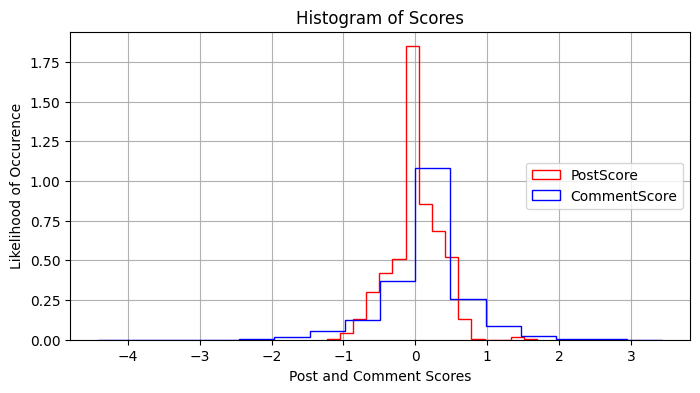

In [239]:
# let's see how our scores came out

n_bins = 16

fig, ax = plt.subplots(figsize=(8,4))

n, bins, patchs = ax.hist(pcss['PostScore'], bins =n_bins, density=True, histtype='step', label='PostScore', color='red')

ax.hist(pcss['CommentScore'], bins =n_bins, density=True, histtype='step', label='CommentScore', color='blue')

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Histogram of Scores')
ax.set_xlabel('Post and Comment Scores')
ax.set_ylabel('Likelihood of Occurence')


plt.show()


Negative Post, Positive Comment:  779
Negative Post, Negative Comment:  649
Positive Post, Negative Comment:  655
Positive Post, Positive Comment:  1442


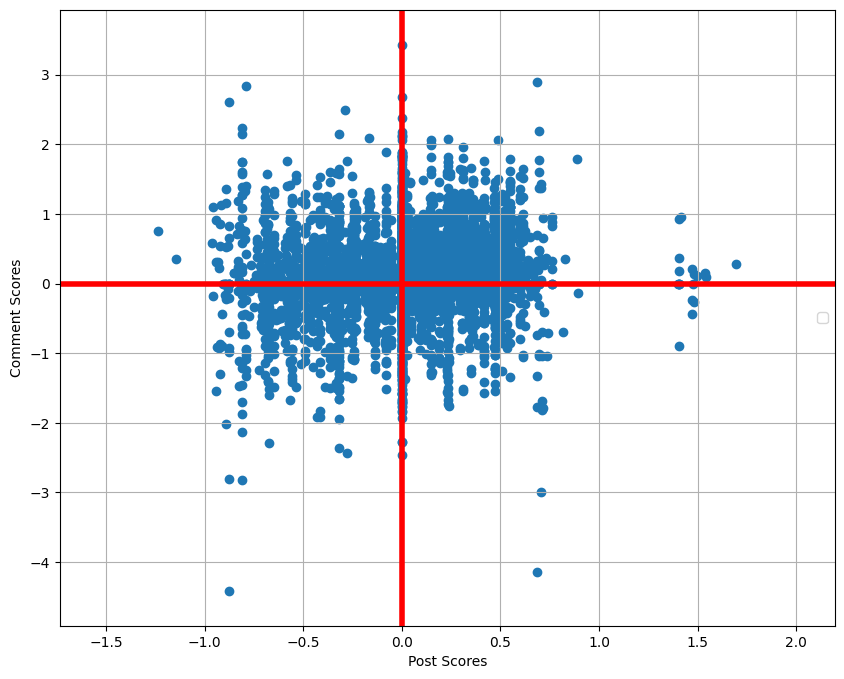

In [301]:
# Now let's visualize this with a scatter plot as well with each post score and corresponding comment score

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(pcss['PostScore'],pcss['CommentScore'])
plt.xlim((min(pcss['PostScore'])-0.5,max(pcss['PostScore'])+0.5))
plt.ylim((min(pcss['CommentScore'])-0.5,max(pcss['CommentScore'])+0.5))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
ax.grid(visible=True, which='major')
ax.legend(loc='right')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')

print('Negative Post, Positive Comment: ' , len(pcss[pcss['PostScore'].lt(0) & pcss['CommentScore'].gt(0)]))
print('Negative Post, Negative Comment: ',len(pcss[pcss['PostScore'].lt(0) & pcss['CommentScore'].lt(0)]))
print('Positive Post, Negative Comment: ',len(pcss[pcss['PostScore'].gt(0) & pcss['CommentScore'].lt(0)]))
print('Positive Post, Positive Comment: ', len(pcss[pcss['PostScore'].gt(0) & pcss['CommentScore'].gt(0)]))
plt.show()

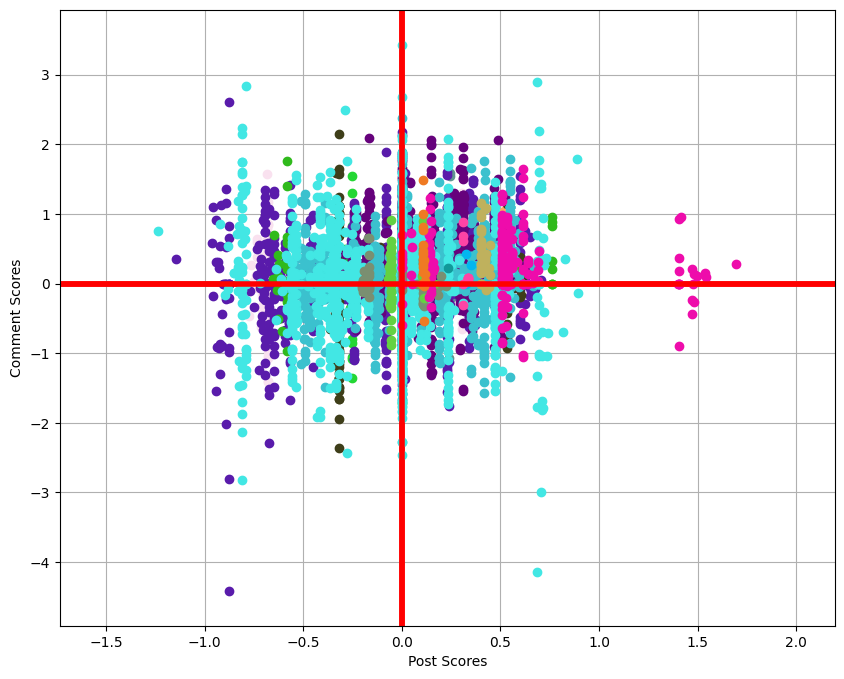

In [302]:
# Now let's see them grouped by company?
fig, ax = plt.subplots(figsize=(10,8))

plt.xlim((min(pcss['PostScore'])-0.5,max(pcss['PostScore'])+0.5))
plt.ylim((min(pcss['CommentScore'])-0.5,max(pcss['CommentScore'])+0.5))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

for company in companies:
    post_vals = pcss[pcss['company'].str.lower().eq(company.lower())][['company','PostScore','CommentScore']]

    ax.plot(post_vals['PostScore'],post_vals['CommentScore'], marker='o', linestyle='', color = get_colors(1)[0], label=company)
plt.xlim((min(pcss['PostScore'])-0.5,max(pcss['PostScore'])+0.5))
plt.ylim((min(pcss['CommentScore'])-0.5,max(pcss['CommentScore'])+0.5))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
ax.grid(visible=True, which='major')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')
plt.show()

Interesting to see all those vertical lines. Hypothesis as to why: When companies create posts, they will do so largely in bulk and post to many subreddits. This would make identical post scores regardless of where they posted. But what is interesting is that the comments that are in reply to these posts are distributed across the CommentScore neutral line. Meaning...

People react differently to products/companies in different subreddits! Kinda cool

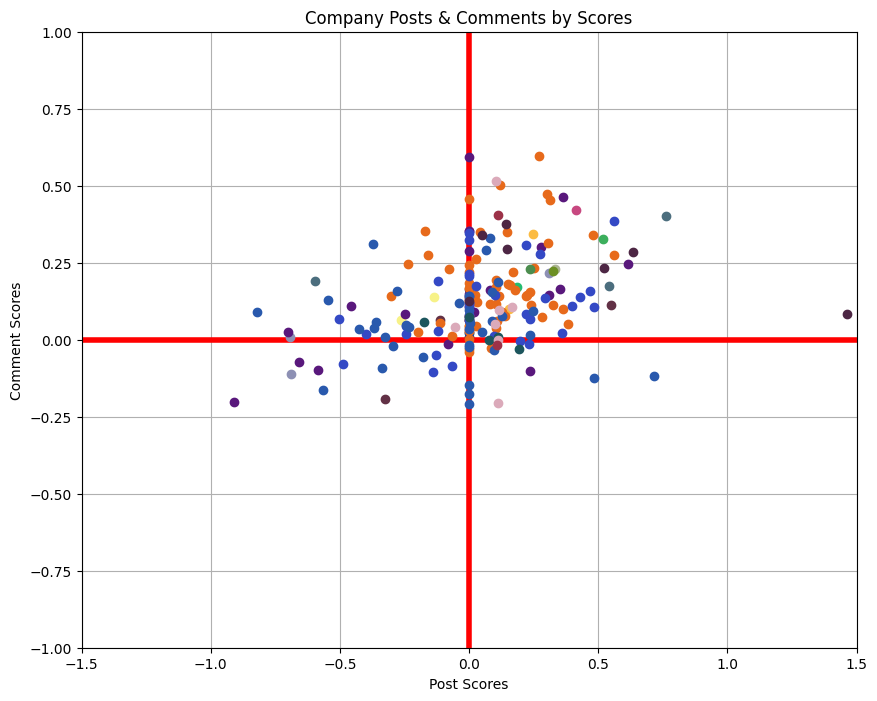

In [303]:
# Now let's see them grouped by company and by post? (We'll use the mean of the comment sentiment as a grouping)
fig, ax = plt.subplots(figsize=(10,8))

plt.xlim((-1.5,1.5))
plt.ylim((-1,1))
plt.plot([-5,5],[0,0], linewidth=4, color='red')
plt.plot([0,0],[-5,5], linewidth=4, color='red')
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

for company in companies:
    post_vals = pcss[pcss['company'].str.lower().eq(company.lower())][['company','post_id','PostScore','CommentScore']]
    grouped_post_vals = post_vals.groupby(['post_id'], as_index=False).agg({'PostScore':'mean','CommentScore':'mean'})
    
    ax.plot(grouped_post_vals['PostScore'],grouped_post_vals['CommentScore'], marker='o', linestyle='', color = get_colors(1)[0], label=company)

ax.grid(visible=True, which='major')
ax.set_title('Company Posts & Comments by Scores')
ax.set_xlabel('Post Scores')
ax.set_ylabel('Comment Scores')
plt.show()

Now that we've used a few useful visualizations, we can start to organize the data into different groupings. 

They are as follows:
- By company
- By post
- By score

Let's see which company has the most posts for us to work with

In [304]:
pcss['company'].value_counts()
# Celcius looks to be our winner here

# In the future, we may want to consider a threshold for posts (e.g. doc.ai is probably not the best)

Celsius                   1453
Algorand                  1362
Ripple                    1099
Coinbase                   930
Robinhood                  283
Oasis Labs                 229
Chainalysis                120
BlockFi                    114
MoonPay                     85
ConsenSys Software Inc      62
TrustToken                  59
Paxos                       45
TaxBit                      36
Bloq                        36
ShipChain                   18
Lemonade                    16
Anchorage Digital           11
Filecoin                    10
Bitfury                      9
Nium                         3
Unstoppable Domains          2
doc.ai                       1
Name: company, dtype: int64

In [305]:
celsius = pcss[pcss['company'].str.lower().eq('celsius')]
celsius.head()
# what we can do is look for the Bi/Tri/Quadgrams that occur and order them by highest sentimentality scores

,company,created,subreddit_id,display_name,public_description,community_reviewed,subscribers,accounts_active,post_id,title,...,upvote_ratio_scaled,total_awards_received_scaled,num_comments_scaled,num_crossposts_scaled,awards_scaled,comment_score_scaled,reply_score_scaled,max_depth_scaled,PostScore,CommentScore
id,,,,,,,,,,,,,,,,,,,,,
2wlj3-xxv8kn-irebo51,Celsius,1.665138e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,xxv8kn,The saga that keeps on giving: Celsius publish...,...,7.894737,4.6875,10.0,10.0,0.000000,4.160632,1.590805,4.615385,0.815480,-0.690748
2wlj3-xxv8kn-irdzxtb,Celsius,1.665138e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,xxv8kn,The saga that keeps on giving: Celsius publish...,...,7.894737,4.6875,10.0,10.0,0.000000,9.216590,3.204598,3.846154,0.895045,-0.134998
2wlj3-xxv8kn-irfi8ce,Celsius,1.665138e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,xxv8kn,The saga that keeps on giving: Celsius publish...,...,7.894737,4.6875,10.0,10.0,3.333333,10.000000,0.303448,2.307692,0.890691,1.789553
2wlj3-xxv8kn-ire6cdy,Celsius,1.665138e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,xxv8kn,The saga that keeps on giving: Celsius publish...,...,7.894737,4.6875,10.0,10.0,0.000000,1.132324,0.491954,1.538462,0.718337,0.647451
2wlj3-xxv8kn-ire0hc2,Celsius,1.665138e+09,2wlj3,CryptoCurrency,"The leading community for cryptocurrency news,...",True,5595418.0,None,xxv8kn,The saga that keeps on giving: Celsius publish...,...,7.894737,4.6875,10.0,10.0,0.000000,2.001317,0.643678,2.307692,0.742473,-0.707767


In [356]:
# we're just going to tackle the 'thread' column here, but this will be easily replicated with the 'title' and 'selftext' columns
celsius_threads = celsius[~celsius['thread'].str.contains(r'automoderator|bot|action performed|deleted|amp', '', flags=re.IGNORECASE)]['thread'].dropna().unique().tolist()

ct = ''.join(celsius_threads)

stoplists = nltk.corpus.stopwords.words()

text = nltk.word_tokenize(ct)
text1 = [w for w in text if w.lower() not in stoplists and w.isalpha()]

# then we can create a text object to use for the Trigram Finder
text = nltk.Text(text1)
finder_bi = nltk.collocations.BigramCollocationFinder.from_words(text)
finder_tri = nltk.collocations.TrigramCollocationFinder.from_words(text)
finder_quad = nltk.collocations.QuadgramCollocationFinder.from_words(text)
bigram = finder_bi.ngram_fd.most_common(50)
trigram = finder_tri.ngram_fd.most_common(50)
quadgram = finder_quad.ngram_fd.most_common(50)
bigram

[(('money', 'back'), 11),
 (('Alex', 'Mashinsky'), 9),
 (('jail', 'time'), 9),
 (('keys', 'coins'), 9),
 (('lost', 'money'), 9),
 (('life', 'savings'), 7),
 (('amount', 'money'), 7),
 (('hardware', 'wallet'), 7),
 (('user', 'funds'), 7),
 (('make', 'money'), 7),
 (('stable', 'coins'), 6),
 (('billion', 'dollars'), 6),
 (('https', 'https'), 5),
 (('lose', 'money'), 5),
 (('lose', 'million'), 5),
 (('Great', 'billion'), 5),
 (('net', 'worth'), 4),
 (('bankruptcy', 'proceedings'), 4),
 (('coins', 'back'), 4),
 (('Holy', 'shit'), 4),
 (('money', 'lost'), 4),
 (('pay', 'back'), 4),
 (('bank', 'account'), 4),
 (('customer', 'funds'), 4),
 (('giving', 'money'), 4),
 (('bull', 'market'), 4),
 (('Celsius', 'Voyager'), 4),
 (('learn', 'hard'), 4),
 (('feel', 'sorry'), 4),
 (('keys', 'crypto'), 4),
 (('required', 'law'), 4),
 (('insider', 'trading'), 4),
 (('money', 'Celsius'), 4),
 (('stuck', 'Celsius'), 4),
 (('interest', 'rates'), 4),
 (('BTC', 'ETH'), 4),
 (('back', 'years'), 4),
 (('insider'

In [357]:
type(bigram[1])

tuple

In [381]:
# now that we have all the important bi/tri/quadgrams, we can find their corresponding comments/posts
bigram_limit = 3
trigram_limit = 2
quadgram_limit = 2


bigrams = [b[0] for b in bigram if b[1] > bigram_limit]
trigrams = [t[0] for t in trigram if t[1] > trigram_limit]
quadgrams = [q[0] for q in quadgram if q[1] > quadgram_limit]

grams = bigrams + trigrams + quadgrams

gv = []

for gram in grams:
    gram_values = {}
    g = '.*'.join(gram)
    cg_thread = celsius[celsius['thread'].str.contains(g,flags=re.IGNORECASE)]
    gram_values['gram'] = gram
    gram_values['average_comment_score'] = cg_thread['CommentScore'].mean()
    gram_values['threads'] = [cg_thread['thread'].to_list()]
    gv.append(gram_values)


gram_df = pd.DataFrame(gv)
gram_df = gram_df.sort_values(by=['average_comment_score'], ascending=False)
gram_df


,gram,average_comment_score,threads
27,"(learn, hard)",0.528884,[[znuffed: I have $138K locked up in Celcius. ...
41,"(Great, billion, dollars)",0.516709,"[[Right-Garage3896: Great, only 2.03 billion d..."
15,"(Great, billion)",0.516709,"[[Right-Garage3896: Great, only 2.03 billion d..."
11,"(billion, dollars)",0.383998,[[6M66: So what happens now? CEO has billions ...
38,"(crypto, projects)",0.290862,[[yayaoa: Hat's off OP you're doing very well....
24,"(giving, money)",0.280125,[[Concept-Plastic: dude wtf I only made 2 txns...
28,"(feel, sorry)",0.257949,[[bullsrfive: I lost 5 figures in Celsius. I a...
18,"(coins, back)",0.250393,[[SmoothBrainSavant: I think alot of folks are...
10,"(stable, coins)",0.234406,[[ToshiBoi: I am so so glad I didn’t get greed...
34,"(interest, rates)",0.203667,[[evieinred: Now shit like this is why I'm alw...


In [ ]:
# An example from a higher sentiment tweet associated with Celsius
# As we can see, there is positive sentiment but it actually appeast to be sarcastic
# this will be something that needs to be proofed repeatedly (espcially with reddit-related jargon)

""""Right-Garage3896: Great, only 2.03 billion dollars to go! --- 

SnackFactory: I thought the hole is under $1B now. Aaron's latest video has some info on it:. . https://youtu.be/wLpU6RqV4g0?t=891. 
    Significant-Leopard9: He's quoting Zach's tweet right? I really don't trust anything Zach or Mashinsky says anymore unless there's another source or if someone can verify these numbers?. . &amp;amp;#x200B;. . Edit: see the latest numbers that Simon retweeted: [https://twitter.com/SimonDixonTwitt/status/1583375561455325184](https://twitter.com/SimonDixonTwitt/status/1583375561455325184). . hole is $2.7bn, NOT under $1bn. I would love for it to be under $1bn but we all know Zach is not to be trusted.. 
Right-Garage3896: Good video, thank you for posting it!,
Right-Garage3896: Great, only 2.03 billion dollars to go!,
CounterAdmirable4218: Great, only 2.03 billion dollars to go!,
ROUNDY_MASS: Great, only 2.03 billion dollars to go!,
Fit-Boomer: Great!  Only 2.0369 billion dollars to go!!,
wavrunrx: Great, only 2.03 billion dollars to go!""""